# Index

1. Preprocesing raw data <br>
    1.1.  Reading files<br>
    1.2. Resizing<br>
    1.3. Splitting data (50%-50% now)<br>
    1.4. Binarization<br>
    1.5. Normalization<br>
2. Model implementation: KNN<br>
    2.1. K-fold validation<br>
    2.2. Grid search<br>

### Libraries

In [312]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Preprocesing raw data

### 1.1 Reading data file

In [313]:
df = pd.read_csv('mfeat-pix.txt', header=None, delimiter='\n')

In [314]:
with open('mfeat-pix.txt') as f:
    raw_dataset = f.readlines()

In [315]:
for i in range(len(raw_dataset)):
    array = raw_dataset[i].split(' ')
    a = np.array('')
    # We do an array with the items
    for item in array:
        a = np.append(a, item)

    # We delete empty items
    a = a[a != ""]

    # We change it from string to float
    a = a.astype('float64')

    if i == 0:
        dataset = a
    else:
        dataset = np.vstack([dataset, a])

### 1.2 Resizing

In [316]:
# Resizing to make 20 groups of 100 images, where each groups has 1 number
dataset = np.resize(dataset, (20, 24000))
dataset = np.array([np.resize(row, (100, 240))for row in dataset])
dataset.shape

(20, 100, 240)

### 1.3 Splitting data (50%-50% now)

In [317]:
# Each X array has 100 images of one number (10 numbers = 1000 images)
X_train = dataset[::2]
X_test = dataset[1::2]
X_train.shape

(10, 100, 240)

In [318]:
# Creating array with the labels.
y_train=[0]
number = 0

for i in range(1,1000):
    if i%100 == 0 and i!=0:
        number+=1
        
    y_train = np.vstack([y_train, number])
    
y_test=y_train
y_train.shape

(1000, 1)

In [319]:
# Creating array with the labels of the original dataset
dataset = np.resize(dataset, (2000, 240))
dataset_labels=[0]
number = 0

for i in range(1,2000):
    if i%200 == 0 and i!=0:
        number+=1
        
    dataset_labels = np.vstack([dataset_labels, number])
dataset.shape, dataset_labels.shape

((2000, 240), (2000, 1))

### 1.4 Binarization of the image

In [320]:
import cv2
retval, X_train = cv2.threshold(src = X_train, thresh =3, maxval=6, type=cv2.THRESH_BINARY)
retval, X_test = cv2.threshold(src = X_test, thresh =3, maxval=6, type=cv2.THRESH_BINARY)

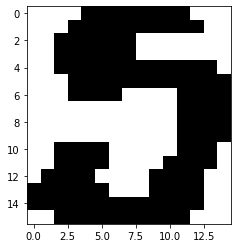

In [321]:
# Display a number to check
display_number = X_train[5]
display_number = np.resize(display_number, (16, 15))

plt.imshow(display_number, cmap='binary')
plt.show()

### 1.5 Normalice data

In [322]:
X_train = X_train/6
X_test = X_test/6

In [323]:
#Resizing
X_train = np.resize(X_train, (1000, 240))
X_test = np.resize(X_test, (1000, 240))

In [324]:
X_train.shape

(1000, 240)

-----------
# 2. Model implementation: KNN

### With the original data

In [325]:
from sklearn.neighbors import KNeighborsClassifier

In [326]:
# Build and train the model with the value selected: k= 9
KNN = KNeighborsClassifier(n_neighbors=9)
KNN.fit(X_train, y_train.ravel())

KNeighborsClassifier(n_neighbors=9)

In [327]:
# We predict the labels of the test data
y_pred = KNN.predict(X_test)
y_test = np.resize(y_test,(1000,))

In [328]:
y_test.shape

(1000,)

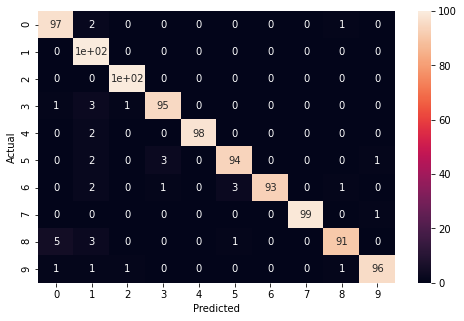

In [329]:
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix
from sklearn import metrics 
#Confusion matrix to evaluate the model 
plt.figure(figsize=(8,5))
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], 
                               colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)
#plt.savefig("Confusion_Matrix_KNN.png")
plt.show()

In [330]:
# Accuracy of the model
metrics.accuracy_score(y_test, y_pred)

0.963

In [331]:
print(f'More metrics about the model.\n\n' \
      f'{metrics.classification_report(y_test, y_pred, labels=[0.0, 1.0, 2.0, 3.0, 4.0])}')

More metrics about the model.

              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95       100
         1.0       0.87      1.00      0.93       100
         2.0       0.98      1.00      0.99       100
         3.0       0.96      0.95      0.95       100
         4.0       1.00      0.98      0.99       100

   micro avg       0.95      0.98      0.96       500
   macro avg       0.95      0.98      0.96       500
weighted avg       0.95      0.98      0.96       500



#### Kerner PCA dimension reduction

In [332]:
X_train.shape, y_train.shape

((1000, 240), (1000, 1))

In [333]:
from sklearn.decomposition import KernelPCA
pcakernel = KernelPCA(n_components=18, kernel='rbf')
X_train_reduced = pcakernel.fit_transform(X_train)
X_test_reduced = pcakernel.transform(X_test)

In [334]:
# Build and train the model with the value selected: k= 9
KNN = KNeighborsClassifier(n_neighbors=9)
KNN.fit(X_train_reduced, y_train.ravel())

KNeighborsClassifier(n_neighbors=9)

In [335]:
# We predict the labels of the test data
y_pred = KNN.predict(X_test_reduced)
y_pred.shape, X_train.shape

((1000,), (1000, 240))

In [336]:
# Accuracy of the model
metrics.accuracy_score(y_test, y_pred)

0.966

###  2.1 K-fold validation

In [337]:
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

def k_fold(folds):
    split_data = KFold(n_splits = folds, shuffle = True, random_state = np.random.RandomState(5))
    return split_data, folds

In [338]:
dt_k, dt_folds = k_fold(3)
dt_k_, dt_folds_ = k_fold(5)

input_data = dataset
label_data = dataset_labels.ravel()

result = cross_val_score(KNN , input_data, label_data, cv = dt_k)
print(f"Average accuracy from 3 folds: {result.mean()}\n")
result_ = cross_val_score(KNN , input_data, label_data, cv = dt_k_)
print(f"Average accuracy from 5 folds: {result_.mean()}")



Average accuracy from 3 folds: 0.9704997351174263

Average accuracy from 5 folds: 0.9744999999999999


### 2.2 Grid search

In [339]:
# Make a search space ->> make a dictionary of hyperparameter values to search

search_space={
    'n_neighbors': (1,10, 1),
    'leaf_size': (20,40,1),
    'p': (1,2),
    'weights': ('uniform', 'distance'),
    'metric': ('minkowski', 'chebyshev'),
}

In [340]:
# Make a GridSearchCV object 
grid_search_KNN = GridSearchCV(
    estimator=KNN, # Model that we are going to use
    param_grid=search_space, # The search space
    scoring = 'accuracy', # Scoring methods
    cv = 5,
)

In [341]:
grid_search_KNN.fit(X_train_reduced, y_train.ravel())

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=9),
             param_grid={'leaf_size': (20, 40, 1),
                         'metric': ('minkowski', 'chebyshev'),
                         'n_neighbors': (1, 10, 1), 'p': (1, 2),
                         'weights': ('uniform', 'distance')},
             scoring='accuracy')

In [342]:
print(grid_search_KNN.best_params_)

{'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}


In [343]:
#Rest parameters are default in class object.
KNN_best_ = KNeighborsClassifier(leaf_size= 20, metric= 'minkowski', n_neighbors= 10, p= 2, weights= 'distance')

result_ = cross_val_score(KNN_best_ , input_data, label_data, cv = dt_k_)
print(f'Decision tree accuracy score with {dt_folds_} and optimal parameters: {result_.mean()}')

Decision tree accuracy score with 5 and optimal parameters: 0.9755
